# 作业五：机器翻译
使用seq2seq模型完成英语-->繁体中文的翻译任务，数据集来自TED演讲，使用BLEU分数来评价模型
训练技巧：
- Tokenize data with sub-word units：子词汇切分 使用子字单元标记数据
- Label smoothing regularization：标签平滑化 计算loss时对不正确的标签也保留一些概率，这样可以避免过拟合
- Learning rate scheduling：学习率调整 采用warm-up机制
- Back translation：反向翻译 比如当前的这个任务，可以再训一个中文到英语的任务，然后拿中文单语言词库反向生成英语词汇，进而作为模型训练的补充资料

### 安装必要的包

In [1]:
# %pip install editdistance sacrebleu sacremoses sentencepiece tqdm wandb
# %pip install --upgrade jupyter ipywidgets
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# %pip install --upgrade ./fairseq/

In [2]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

In [3]:
# set seed
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### 下载数据集

双语言数据库：TED2020

Raw: 398,066 (sentences)

Processed: 393,980 (sentences)

测试集：Size: 4,000 (sentences)

中文翻译未公开。提供的（.zh）文件是伪翻译，每一行都是一个'。'

In [4]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
!rm -rf {prefix/'test'}

raw.en
raw.zh
test/
test/test.zh
test/test.en


In [5]:
# language
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [6]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


### 预处理

In [7]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"【（）】*", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"【（）】*", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)
     

In [8]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [9]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


### 划分训练集和验证集

In [10]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [11]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


### 子词汇单元
机器翻译中常出现未登录词 Out-of-vocabulary（OOV）的问题，就是训练时未出现，测试时出现了的单词。使用子词汇划分(subword units)的方法可以缓解这种情况

我们使用sentencepiece库，使用 'unigram' 或 'byte-pair encoding (BPE)' 算法

In [12]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [13]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [14]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


### 使用fairseq库二值化数据

In [15]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


### 实验设置

In [16]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/transformer",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=40,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=True,
)

### 日志输出

In [17]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5_transformer"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

2023-01-20 10:37:14 | ERROR | wandb.jupyter | Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: richard_wang. Use `wandb login --relogin` to force relogin


### CUDA环境

In [18]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-01-20 10:37:18 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-01-20 10:37:18 | INFO | fairseq.utils | rank   0: capabilities =  5.2  ; total memory = 23.905 GB ; name = Tesla M40 24GB                          
2023-01-20 10:37:18 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


### 数据集加载
我们采用现成的功能强大的fairseq库来实现

In [19]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-01-20 10:37:19 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2023-01-20 10:37:19 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [20]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-01-20 10:37:19 | INFO | hw5_transformer | loading data for epoch 1
2023-01-20 10:37:19 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2023-01-20 10:37:19 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2023-01-20 10:37:19 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2023-01-20 10:37:19 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2023-01-20 10:37:19 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2023-01-20 10:37:19 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [21]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


### 数据集迭代器

- 控制每个批次包含不超过 N 个令牌，从而优化 GPU 内存效率
- 为每个时期打乱训练集
- 忽略超过最大长度的句子
- 将一批中的所有句子填充到相同的长度，从而实现 GPU 的并行计算
- 添加eos并转移一个令牌
    - teacher forcing：为了训练模型根据前缀预测下一个标记，我们将右移的目标序列作为解码器输入。
    - 通常，将 bos 添加到目标之前就可以完成这项工作

In [22]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-01-20 10:37:20 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

### 模型架构
这里直接采用Transformer架构

In [23]:
from fairseq.models import FairseqEncoder, FairseqIncrementalDecoder,FairseqEncoderDecoderModel

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores
    
# Seq2Seq模型
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra
    
# 模型初始化
from fairseq.models.transformer import TransformerEncoder, TransformerDecoder

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

### 模型参数设置

In [25]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=6,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="gelu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)
     

if config.use_wandb:
    wandb.config.update(vars(arch_args))
     

model = build_model(arch_args, task)
logger.info(model)

2023-01-20 10:40:05 | INFO | hw5_transformer | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, b

## 接下来是各种优化

### 损失函数：标签平滑化
给ground truth外的标签也加上一点概率，可以减少过拟合的问题

In [26]:
# code from https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

### 优化器：Adam + learning rate scheduler
采用warm-up的方法

$$ \text{lrate}=d_{\text{model}}^{-0.5}\times min(\text{step-num}^{-0.5}, \text{step-num}\times \text{warmup-steps}^{-1.5}) $$

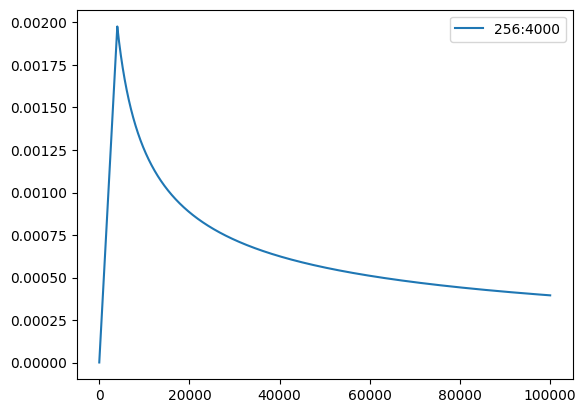

In [27]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    # lr = 0.001
    lr = pow(d_model, -0.5) * min(pow(step_num, -0.5), step_num * pow(warmup_step, -1.5))
    return lr
     

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)
     
# Scheduling Visualized
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

### 训练

In [28]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

### 验证和测试

In [29]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else ""

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [30]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

### 保存模型

In [31]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

### 主函数

In [32]:
model = model.to(device=device)
criterion = criterion.to(device=device)
     

logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")
     

epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-01-20 10:40:12 | INFO | hw5_transformer | task: TranslationTask
2023-01-20 10:40:12 | INFO | hw5_transformer | encoder: TransformerEncoder
2023-01-20 10:40:12 | INFO | hw5_transformer | decoder: TransformerDecoder
2023-01-20 10:40:12 | INFO | hw5_transformer | criterion: LabelSmoothedCrossEntropyCriterion
2023-01-20 10:40:12 | INFO | hw5_transformer | optimizer: NoamOpt
2023-01-20 10:40:12 | INFO | hw5_transformer | num. model params: 13,580,288 (num. trained: 13,580,288)
2023-01-20 10:40:12 | INFO | hw5_transformer | max tokens per batch = 8192, accumulate steps = 2
2023-01-20 10:40:12 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2023-01-20 10:40:12 | INFO | hw5_transformer | no checkpoints found at checkpoints/transformer/checkpoint_last.pt!


train epoch 1:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 10:49:38 | INFO | hw5_transformer | training loss: 7.0275
2023-01-20 10:49:38 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ruizhe/miniconda3/envs/d2l-zh/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/ruizhe/miniconda3/envs/d2l-zh/lib/python3.8/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // b

2023-01-20 10:50:14 | INFO | hw5_transformer | example source: but the point is , it doesn't feel that way .
2023-01-20 10:50:14 | INFO | hw5_transformer | example hypothesis: 但 , 但 , 但 , 但 , 很棒 。
2023-01-20 10:50:14 | INFO | hw5_transformer | example reference: 但重點是 , 感覺起來卻不是那麼回事呀
2023-01-20 10:50:14 | INFO | hw5_transformer | validation loss:	5.9515
2023-01-20 10:50:14 | INFO | hw5_transformer | BLEU = 0.99 20.2/3.3/0.7/0.1 (BP = 0.651 ratio = 0.700 hyp_len = 78230 ref_len = 111811)
2023-01-20 10:50:14 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint1.pt
2023-01-20 10:50:15 | INFO | hw5_transformer | end of epoch 1


train epoch 2:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 10:59:38 | INFO | hw5_transformer | training loss: 5.4489
2023-01-20 10:59:38 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 11:00:09 | INFO | hw5_transformer | example source: we can push through that .
2023-01-20 11:00:09 | INFO | hw5_transformer | example hypothesis: 我們可以把這個轉換 。
2023-01-20 11:00:09 | INFO | hw5_transformer | example reference: 我們可以衝破這些限制 。
2023-01-20 11:00:09 | INFO | hw5_transformer | validation loss:	4.8927
2023-01-20 11:00:09 | INFO | hw5_transformer | BLEU = 7.98 41.1/15.9/6.6/2.9 (BP = 0.757 ratio = 0.782 hyp_len = 87430 ref_len = 111811)
2023-01-20 11:00:09 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint2.pt
2023-01-20 11:00:09 | INFO | hw5_transformer | end of epoch 2


train epoch 3:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 11:09:30 | INFO | hw5_transformer | training loss: 4.8273
2023-01-20 11:09:30 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 11:10:04 | INFO | hw5_transformer | example source: thank you .
2023-01-20 11:10:04 | INFO | hw5_transformer | example hypothesis: 謝謝 。
2023-01-20 11:10:04 | INFO | hw5_transformer | example reference: 謝謝 。
2023-01-20 11:10:04 | INFO | hw5_transformer | validation loss:	4.4599
2023-01-20 11:10:04 | INFO | hw5_transformer | BLEU = 11.78 44.4/19.2/9.1/4.6 (BP = 0.860 ratio = 0.869 hyp_len = 97136 ref_len = 111811)
2023-01-20 11:10:04 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint3.pt
2023-01-20 11:10:04 | INFO | hw5_transformer | end of epoch 3


train epoch 4:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 11:19:32 | INFO | hw5_transformer | training loss: 4.5068
2023-01-20 11:19:32 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 11:20:11 | INFO | hw5_transformer | example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2023-01-20 11:20:11 | INFO | hw5_transformer | example hypothesis: 這些男性最終會被判斷 , 用1500磅的優勢 , 到世界上許多貿易中心 , 造成許多貿易貿易中心 , 包括北部 , 到北部 , 殺死了六萬人 , 殺死了超過六萬人 。
2023-01-20 11:20:11 | INFO | hw5_transformer | example reference: 這群男人最終被指控將滿載1500磅重的炸彈的廂式貨車停在世界貿易中心北塔的地下停車場 , 爆炸造成6人死亡 , 同時致使超過1000人受傷 。
2023-01-20 11:20:11 | INFO | hw5_transformer | validation loss:	4.1878
2023-01-20 11:20:11 | INFO | hw5_transformer | BLEU = 14.95 46.0/21.5/10.8/5.7 (BP = 0.949 ratio = 0.951 hyp_len = 106297 ref_len = 111811)
2023-01-20 11:20:11 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint4.pt
2023-01-20 11:20:11 | INFO | hw

train epoch 5:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 11:29:36 | INFO | hw5_transformer | training loss: 4.2924
2023-01-20 11:29:36 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 11:30:16 | INFO | hw5_transformer | example source: but this is really how i go about creating these photographs .
2023-01-20 11:30:16 | INFO | hw5_transformer | example hypothesis: 但這真的是我如何創造這些照片的照片 。
2023-01-20 11:30:16 | INFO | hw5_transformer | example reference: 但是我真的是這樣做出這些相片的 。
2023-01-20 11:30:16 | INFO | hw5_transformer | validation loss:	4.0538
2023-01-20 11:30:16 | INFO | hw5_transformer | BLEU = 17.00 47.9/23.4/12.3/6.7 (BP = 0.974 ratio = 0.974 hyp_len = 108932 ref_len = 111811)
2023-01-20 11:30:16 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint5.pt
2023-01-20 11:30:16 | INFO | hw5_transformer | end of epoch 5


train epoch 6:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 11:39:40 | INFO | hw5_transformer | training loss: 4.1441
2023-01-20 11:39:40 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 11:40:16 | INFO | hw5_transformer | example source: so that is a fact .
2023-01-20 11:40:16 | INFO | hw5_transformer | example hypothesis: 所以這是事實 。
2023-01-20 11:40:16 | INFO | hw5_transformer | example reference: 這就是事實
2023-01-20 11:40:16 | INFO | hw5_transformer | validation loss:	3.9090
2023-01-20 11:40:16 | INFO | hw5_transformer | BLEU = 18.44 51.5/26.0/13.9/7.9 (BP = 0.940 ratio = 0.942 hyp_len = 105335 ref_len = 111811)
2023-01-20 11:40:17 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint6.pt
2023-01-20 11:40:17 | INFO | hw5_transformer | end of epoch 6


train epoch 7:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 11:49:40 | INFO | hw5_transformer | training loss: 4.0051
2023-01-20 11:49:40 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 11:50:16 | INFO | hw5_transformer | example source: thank you so much everyone .
2023-01-20 11:50:16 | INFO | hw5_transformer | example hypothesis: 感謝大家 。
2023-01-20 11:50:16 | INFO | hw5_transformer | example reference: 謝謝大家 !
2023-01-20 11:50:16 | INFO | hw5_transformer | validation loss:	3.8232
2023-01-20 11:50:16 | INFO | hw5_transformer | BLEU = 18.96 52.7/27.1/14.8/8.5 (BP = 0.920 ratio = 0.923 hyp_len = 103249 ref_len = 111811)
2023-01-20 11:50:16 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint7.pt
2023-01-20 11:50:17 | INFO | hw5_transformer | end of epoch 7


train epoch 8:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 11:59:43 | INFO | hw5_transformer | training loss: 3.9069
2023-01-20 11:59:43 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 12:00:18 | INFO | hw5_transformer | example source: these differences became a source of inspired artistic celebration .
2023-01-20 12:00:18 | INFO | hw5_transformer | example hypothesis: 這些差異變成了靈感藝術慶祝的來源 。
2023-01-20 12:00:18 | INFO | hw5_transformer | example reference: 這些差異變成了一個源頭 , 富有靈感之藝術讚頌的源頭 。
2023-01-20 12:00:18 | INFO | hw5_transformer | validation loss:	3.7368
2023-01-20 12:00:18 | INFO | hw5_transformer | BLEU = 19.53 55.1/29.0/16.0/9.3 (BP = 0.885 ratio = 0.891 hyp_len = 99659 ref_len = 111811)
2023-01-20 12:00:18 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint8.pt
2023-01-20 12:00:18 | INFO | hw5_transformer | end of epoch 8


train epoch 9:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 12:09:43 | INFO | hw5_transformer | training loss: 3.8316
2023-01-20 12:09:43 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 12:10:21 | INFO | hw5_transformer | example source: it's not .
2023-01-20 12:10:21 | INFO | hw5_transformer | example hypothesis: 不是 。
2023-01-20 12:10:21 | INFO | hw5_transformer | example reference: 不是
2023-01-20 12:10:21 | INFO | hw5_transformer | validation loss:	3.7037
2023-01-20 12:10:21 | INFO | hw5_transformer | BLEU = 21.05 53.6/28.2/15.7/9.2 (BP = 0.974 ratio = 0.975 hyp_len = 108971 ref_len = 111811)
2023-01-20 12:10:21 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint9.pt
2023-01-20 12:10:21 | INFO | hw5_transformer | end of epoch 9


train epoch 10:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 12:19:44 | INFO | hw5_transformer | training loss: 3.7740
2023-01-20 12:19:44 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 12:20:19 | INFO | hw5_transformer | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2023-01-20 12:20:19 | INFO | hw5_transformer | example hypothesis: 所以 , 想想你有朋友、家人、在加州的同事、在西岸或其他地區的西岸 。
2023-01-20 12:20:19 | INFO | hw5_transformer | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2023-01-20 12:20:19 | INFO | hw5_transformer | validation loss:	3.6461
2023-01-20 12:20:19 | INFO | hw5_transformer | BLEU = 21.40 55.7/29.8/16.8/9.9 (BP = 0.933 ratio = 0.936 hyp_len = 104612 ref_len = 111811)
2023-01-20 12:20:19 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint10.pt
2023-01-20 12:20:19 | INFO | hw5_transformer | end of epoch 10


train epoch 11:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 12:29:44 | INFO | hw5_transformer | training loss: 3.7276
2023-01-20 12:29:44 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 12:30:25 | INFO | hw5_transformer | example source: and i was asked to move out because one of my roommates had shared my status with her parents .
2023-01-20 12:30:25 | INFO | hw5_transformer | example hypothesis: 我被要求離開 , 因為我的其中一位室友和她的父母分享我的地位 。
2023-01-20 12:30:25 | INFO | hw5_transformer | example reference: 我會被要求搬出去 , 是因為其中一名室友和她的父母談了我的狀況 。
2023-01-20 12:30:25 | INFO | hw5_transformer | validation loss:	3.6226
2023-01-20 12:30:25 | INFO | hw5_transformer | BLEU = 22.02 55.0/29.5/16.7/9.9 (BP = 0.966 ratio = 0.967 hyp_len = 108114 ref_len = 111811)
2023-01-20 12:30:25 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint11.pt
2023-01-20 12:30:25 | INFO | hw5_transformer | end of epoch 11


train epoch 12:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 12:39:52 | INFO | hw5_transformer | training loss: 3.6910
2023-01-20 12:39:52 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 12:40:28 | INFO | hw5_transformer | example source: and i want to share with you a quick video from our facility that gives you a sense of how this looks at scale .
2023-01-20 12:40:28 | INFO | hw5_transformer | example hypothesis: 我想要和各位分享一個快速的影片 , 可以讓你了解這個規模的規模 。
2023-01-20 12:40:28 | INFO | hw5_transformer | example reference: 我想與你們快速分享一段關於我們設備的影片可以瞭解一下它的規模
2023-01-20 12:40:28 | INFO | hw5_transformer | validation loss:	3.5792
2023-01-20 12:40:28 | INFO | hw5_transformer | BLEU = 22.16 56.1/30.3/17.3/10.4 (BP = 0.943 ratio = 0.945 hyp_len = 105630 ref_len = 111811)
2023-01-20 12:40:28 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint12.pt
2023-01-20 12:40:28 | INFO | hw5_transformer | end of epoch 12


train epoch 13:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 12:49:45 | INFO | hw5_transformer | training loss: 3.6577
2023-01-20 12:49:45 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 12:50:20 | INFO | hw5_transformer | example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2023-01-20 12:50:20 | INFO | hw5_transformer | example hypothesis: 可能是兩位諾貝爾獎得主 , 理查費曼和約翰納什 。
2023-01-20 12:50:20 | INFO | hw5_transformer | example reference: 我們或許可以從兩位諾貝爾獎得主 , 理查費曼和約翰奈許之間看出這樣的差異 。
2023-01-20 12:50:20 | INFO | hw5_transformer | validation loss:	3.5645
2023-01-20 12:50:20 | INFO | hw5_transformer | BLEU = 22.11 57.2/31.1/17.8/10.8 (BP = 0.914 ratio = 0.918 hyp_len = 102624 ref_len = 111811)
2023-01-20 12:50:20 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint13.pt
2023-01-20 12:50:20 | INFO | hw5_transformer | end of epoch 13


train epoch 14:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 12:59:45 | INFO | hw5_transformer | training loss: 3.6304
2023-01-20 12:59:45 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 13:00:22 | INFO | hw5_transformer | example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2023-01-20 13:00:22 | INFO | hw5_transformer | example hypothesis: 還有一個年輕女孩的智慧 , 永遠影響我 。
2023-01-20 13:00:22 | INFO | hw5_transformer | example reference: 她說的話對我有很大啟發 。 這一個年幼女孩短暫的一生永遠影響著我 。
2023-01-20 13:00:22 | INFO | hw5_transformer | validation loss:	3.5491
2023-01-20 13:00:22 | INFO | hw5_transformer | BLEU = 21.63 58.4/31.9/18.2/11.0 (BP = 0.876 ratio = 0.883 hyp_len = 98725 ref_len = 111811)
2023-01-20 13:00:22 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint14.pt
2023-01-20 13:00:23 | INFO | hw5_transformer | end of epoch 14


train epoch 15:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 13:09:49 | INFO | hw5_transformer | training loss: 3.6115
2023-01-20 13:09:49 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 13:10:23 | INFO | hw5_transformer | example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2023-01-20 13:10:23 | INFO | hw5_transformer | example hypothesis: 我們開始做曲線 , 不僅是美麗的 , 人們還能看到你在乎你的孩子的現狀 。
2023-01-20 13:10:23 | INFO | hw5_transformer | example reference: 我們也開始生産窗簾不止因爲窗簾看起來漂亮 , 人們也可以看到你的地位看得出你很關心小孩
2023-01-20 13:10:23 | INFO | hw5_transformer | validation loss:	3.5343
2023-01-20 13:10:23 | INFO | hw5_transformer | BLEU = 22.31 57.9/31.8/18.3/11.0 (BP = 0.904 ratio = 0.908 hyp_len = 101551 ref_len = 111811)
2023-01-20 13:10:23 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint15.pt
2023-01-20 13:10:23 | INFO | hw5_transformer | end of epoch 15


train epoch 16:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 13:19:44 | INFO | hw5_transformer | training loss: 3.5849
2023-01-20 13:19:44 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 13:20:23 | INFO | hw5_transformer | example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2023-01-20 13:20:23 | INFO | hw5_transformer | example hypothesis: 我並不是建議我們要在我們的胃裡養育我們的寶寶 , 但我建議 , 我們可能想在腸道上管理天然氣污染 。
2023-01-20 13:20:23 | INFO | hw5_transformer | example reference: 我並不是說要把嬰兒養在胃裡而是我們可能可以了解胃在內臟裡的分泌物
2023-01-20 13:20:23 | INFO | hw5_transformer | validation loss:	3.5184
2023-01-20 13:20:23 | INFO | hw5_transformer | BLEU = 23.15 56.9/31.2/18.0/11.0 (BP = 0.950 ratio = 0.952 hyp_len = 106404 ref_len = 111811)
2023-01-20 13:20:23 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint16.pt
2023-01-20 13:20:23 | INFO | hw5_transformer | end of epoch 16


train epoch 17:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 13:29:44 | INFO | hw5_transformer | training loss: 3.5665
2023-01-20 13:29:44 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 13:30:24 | INFO | hw5_transformer | example source: so we're hoping that's what they'll do .
2023-01-20 13:30:24 | INFO | hw5_transformer | example hypothesis: 所以 , 我們希望這是他們會做的 。
2023-01-20 13:30:24 | INFO | hw5_transformer | example reference: 所以 , 我們希望它們能夠幫忙 。
2023-01-20 13:30:24 | INFO | hw5_transformer | validation loss:	3.5092
2023-01-20 13:30:24 | INFO | hw5_transformer | BLEU = 23.36 56.5/30.9/17.8/10.9 (BP = 0.968 ratio = 0.969 hyp_len = 108334 ref_len = 111811)
2023-01-20 13:30:25 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint17.pt
2023-01-20 13:30:25 | INFO | hw5_transformer | end of epoch 17


train epoch 18:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 13:39:44 | INFO | hw5_transformer | training loss: 3.5487
2023-01-20 13:39:44 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 13:40:17 | INFO | hw5_transformer | example source: i remember so vividly that day .
2023-01-20 13:40:17 | INFO | hw5_transformer | example hypothesis: 那天我非常清楚記得 。
2023-01-20 13:40:17 | INFO | hw5_transformer | example reference: 我對那一天還記憶猶新 。
2023-01-20 13:40:17 | INFO | hw5_transformer | validation loss:	3.5054
2023-01-20 13:40:17 | INFO | hw5_transformer | BLEU = 22.88 58.2/32.1/18.6/11.4 (BP = 0.912 ratio = 0.916 hyp_len = 102415 ref_len = 111811)
2023-01-20 13:40:17 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint18.pt
2023-01-20 13:40:17 | INFO | hw5_transformer | end of epoch 18


train epoch 19:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 13:49:45 | INFO | hw5_transformer | training loss: 3.5333
2023-01-20 13:49:45 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 13:50:19 | INFO | hw5_transformer | example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2023-01-20 13:50:19 | INFO | hw5_transformer | example hypothesis: 下一步是要做出複雜的腳趾 , 試著加上脊椎和爪子 , 為乾燥的黏著劑設定 。
2023-01-20 13:50:19 | INFO | hw5_transformer | example reference: 下一步是要製造順從聽話的腳趾頭 。 然後加上刺和爪子 , 再加上乾膠 。
2023-01-20 13:50:19 | INFO | hw5_transformer | validation loss:	3.4779
2023-01-20 13:50:19 | INFO | hw5_transformer | BLEU = 23.38 57.8/32.0/18.6/11.4 (BP = 0.934 ratio = 0.936 hyp_len = 104674 ref_len = 111811)
2023-01-20 13:50:19 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint19.pt
2023-01-20 13:50:19 | INFO | hw5_transformer | end of epoch 19


train epoch 20:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 13:59:44 | INFO | hw5_transformer | training loss: 3.5178
2023-01-20 13:59:44 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 14:00:19 | INFO | hw5_transformer | example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2023-01-20 14:00:19 | INFO | hw5_transformer | example hypothesis: 把嬰兒的脖子從嬰兒的脖子裡拿走 , 健康的尖叫 , 刀刀寶從停車場跑進來 , 「 嗨 , 你有兒子 , 我是darria醫生 。
2023-01-20 14:00:19 | INFO | hw5_transformer | example reference: 我把臍帶從嬰兒的脖子繞開 , 接著 , 一個健康哭鬧的嬰兒誕生了 。 同時 , 他的父親剛從停車場趕來 。 「 你好 , 是一個男孩 。 我是達里亞醫生 。
2023-01-20 14:00:19 | INFO | hw5_transformer | validation loss:	3.4775
2023-01-20 14:00:19 | INFO | hw5_transformer | BLEU = 23.55 57.3/31.7/18.5/11.3 (BP = 0.949 ratio = 0.950 hyp_len = 106197 ref_len = 111811)
2023-01-20 14:00:19 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint20.pt
2023-01-20 14:00:19 | INFO | hw5_transformer | end of epoch 20


train epoch 21:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 14:09:47 | INFO | hw5_transformer | training loss: 3.5081
2023-01-20 14:09:47 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 14:10:22 | INFO | hw5_transformer | example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2023-01-20 14:10:22 | INFO | hw5_transformer | example hypothesis: 不 , 但在民主中 , 城市建築的問題很有趣 , 因為它創造混亂 , 對吧 ?
2023-01-20 14:10:22 | INFO | hw5_transformer | example reference: 不 , 但民主的城市建設很有趣 , 因為會造成混亂 , 是嗎 ?
2023-01-20 14:10:22 | INFO | hw5_transformer | validation loss:	3.4671
2023-01-20 14:10:22 | INFO | hw5_transformer | BLEU = 23.90 57.2/31.7/18.4/11.3 (BP = 0.965 ratio = 0.966 hyp_len = 107982 ref_len = 111811)
2023-01-20 14:10:22 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint21.pt
2023-01-20 14:10:22 | INFO | hw5_transformer | end of epoch 21


train epoch 22:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 14:19:42 | INFO | hw5_transformer | training loss: 3.4904
2023-01-20 14:19:42 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 14:20:16 | INFO | hw5_transformer | example source: so i'm going to show you a demo of this .
2023-01-20 14:20:16 | INFO | hw5_transformer | example hypothesis: 所以我要給你們看一個示範 。
2023-01-20 14:20:16 | INFO | hw5_transformer | example reference: 現在請各位看示範
2023-01-20 14:20:16 | INFO | hw5_transformer | validation loss:	3.4682
2023-01-20 14:20:16 | INFO | hw5_transformer | BLEU = 23.70 58.0/32.2/18.8/11.5 (BP = 0.941 ratio = 0.942 hyp_len = 105362 ref_len = 111811)
2023-01-20 14:20:16 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint22.pt
2023-01-20 14:20:16 | INFO | hw5_transformer | end of epoch 22


train epoch 23:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 14:29:37 | INFO | hw5_transformer | training loss: 3.4814
2023-01-20 14:29:37 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 14:30:14 | INFO | hw5_transformer | example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2023-01-20 14:30:14 | INFO | hw5_transformer | example hypothesis: 你看 , 在每個國家 , 你聽到武裝的聖戰人員 , 也有一些未武裝的人 , 那些你聽不到的軍人 , 而那些人需要我們的支持才能成功 。
2023-01-20 14:30:14 | INFO | hw5_transformer | example reference: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2023-01-20 14:30:14 | INFO | hw5_transformer | validation loss:	3.4581
2023-01-20 14:30:14 | INFO | hw5_transformer | BLEU = 23.34 58.8/32.7/19.1/11.7 (BP = 0.911 ratio = 0.915 hyp_len = 102305 ref_len = 111811)
2023-01-20 14:30:14 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint23.pt
2023-01-20 14:30:14 | INFO | hw5_transformer | end of epoch 23


train epoch 24:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 14:39:37 | INFO | hw5_transformer | training loss: 3.4693
2023-01-20 14:39:37 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 14:40:11 | INFO | hw5_transformer | example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2023-01-20 14:40:11 | INFO | hw5_transformer | example hypothesis: 從gezi到tahrir到其他地方 , 我見過人們把他們的生活和生活放在線上 。
2023-01-20 14:40:11 | INFO | hw5_transformer | example reference: 從格濟公園 , 到解放廣場 , 再到其它地方 , 我見過許多人用他們的生命和生計做賭注 。
2023-01-20 14:40:11 | INFO | hw5_transformer | validation loss:	3.4582
2023-01-20 14:40:11 | INFO | hw5_transformer | BLEU = 23.68 58.4/32.5/19.0/11.7 (BP = 0.931 ratio = 0.933 hyp_len = 104325 ref_len = 111811)
2023-01-20 14:40:11 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint24.pt
2023-01-20 14:40:11 | INFO | hw5_transformer | end of epoch 24


train epoch 25:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 14:49:36 | INFO | hw5_transformer | training loss: 3.4615
2023-01-20 14:49:36 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 14:50:16 | INFO | hw5_transformer | example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2023-01-20 14:50:16 | INFO | hw5_transformer | example hypothesis: 每個專案都已經完全個人化了 , 大家開始評論 , 開始回饋你的程式碼 。
2023-01-20 14:50:16 | INFO | hw5_transformer | example reference: 在那之前每一件計劃都是我個人的東西 , 所以當大家開始評論 , 開始對你的程式給意見時 , 真的是一種啟示 。
2023-01-20 14:50:16 | INFO | hw5_transformer | validation loss:	3.4368
2023-01-20 14:50:16 | INFO | hw5_transformer | BLEU = 24.26 57.2/31.8/18.6/11.5 (BP = 0.972 ratio = 0.972 hyp_len = 108694 ref_len = 111811)
2023-01-20 14:50:16 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint25.pt
2023-01-20 14:50:16 | INFO | hw5_transformer | end of epoch 25


train epoch 26:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 14:59:39 | INFO | hw5_transformer | training loss: 3.4528
2023-01-20 14:59:39 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 15:00:13 | INFO | hw5_transformer | example source: thank you so much .
2023-01-20 15:00:13 | INFO | hw5_transformer | example hypothesis: 謝謝
2023-01-20 15:00:13 | INFO | hw5_transformer | example reference: 感謝各位.
2023-01-20 15:00:13 | INFO | hw5_transformer | validation loss:	3.4432
2023-01-20 15:00:13 | INFO | hw5_transformer | BLEU = 23.34 59.8/33.5/19.7/12.2 (BP = 0.886 ratio = 0.892 hyp_len = 99700 ref_len = 111811)
2023-01-20 15:00:13 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint26.pt
2023-01-20 15:00:13 | INFO | hw5_transformer | end of epoch 26


train epoch 27:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 15:09:36 | INFO | hw5_transformer | training loss: 3.4456
2023-01-20 15:09:36 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 15:10:16 | INFO | hw5_transformer | example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2023-01-20 15:10:16 | INFO | hw5_transformer | example hypothesis: 在六個月之內 , 我們每一個人都能分辨出動畫和無生命物體之間的差異 。
2023-01-20 15:10:16 | INFO | hw5_transformer | example reference: 在六個月大時 , 幾乎每個人都能辨別東西是否有生命 。
2023-01-20 15:10:16 | INFO | hw5_transformer | validation loss:	3.4341
2023-01-20 15:10:16 | INFO | hw5_transformer | BLEU = 24.02 58.8/33.0/19.4/12.0 (BP = 0.927 ratio = 0.929 hyp_len = 103919 ref_len = 111811)
2023-01-20 15:10:16 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint27.pt
2023-01-20 15:10:16 | INFO | hw5_transformer | end of epoch 27


train epoch 28:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 15:19:42 | INFO | hw5_transformer | training loss: 3.4345
2023-01-20 15:19:42 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 15:20:18 | INFO | hw5_transformer | example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2023-01-20 15:20:18 | INFO | hw5_transformer | example hypothesis: 問題是 , 沒有一個可行的民主是由專家、零位、政治人物及觀點組成的 。
2023-01-20 15:20:18 | INFO | hw5_transformer | example reference: 事實上 , 根本沒有一種民主制度是由專家 , 狂熱分子 , 政治家和旁觀者組成的
2023-01-20 15:20:18 | INFO | hw5_transformer | validation loss:	3.4246
2023-01-20 15:20:18 | INFO | hw5_transformer | BLEU = 24.26 57.9/32.3/18.9/11.7 (BP = 0.956 ratio = 0.957 hyp_len = 106998 ref_len = 111811)
2023-01-20 15:20:19 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint28.pt
2023-01-20 15:20:19 | INFO | hw5_transformer | end of epoch 28


train epoch 29:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 15:29:37 | INFO | hw5_transformer | training loss: 3.4273
2023-01-20 15:29:37 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 15:30:11 | INFO | hw5_transformer | example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2023-01-20 15:30:11 | INFO | hw5_transformer | example hypothesis: 他們在學習我們的文化、我們的語言、我們的語言、我們的遺產 , 並了解到我們和彼此的差異 , 和彼此一樣 。
2023-01-20 15:30:11 | INFO | hw5_transformer | example reference: 他們正在習知我們的文化、語言、傳統 , 並意識到彼此不同及相同之處 。
2023-01-20 15:30:11 | INFO | hw5_transformer | validation loss:	3.4204
2023-01-20 15:30:11 | INFO | hw5_transformer | BLEU = 24.31 57.9/32.3/19.0/11.7 (BP = 0.957 ratio = 0.958 hyp_len = 107154 ref_len = 111811)
2023-01-20 15:30:11 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint29.pt
2023-01-20 15:30:11 | INFO | hw5_transformer | end of epoch 29


train epoch 30:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 15:39:36 | INFO | hw5_transformer | training loss: 3.4197
2023-01-20 15:39:36 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 15:40:10 | INFO | hw5_transformer | example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2023-01-20 15:40:10 | INFO | hw5_transformer | example hypothesis: 但你是否知道只有百分之二的資金去重建海地公共機構 , 包括它的健康部門 ?
2023-01-20 15:40:10 | INFO | hw5_transformer | example reference: 但你知不知道國際社會捐款中只有2%用去重建海地的公共體制 , 包括衞生部門 ?
2023-01-20 15:40:10 | INFO | hw5_transformer | validation loss:	3.4244
2023-01-20 15:40:10 | INFO | hw5_transformer | BLEU = 23.93 58.5/32.6/19.1/11.7 (BP = 0.937 ratio = 0.939 hyp_len = 104987 ref_len = 111811)
2023-01-20 15:40:11 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint30.pt
2023-01-20 15:40:11 | INFO | hw5_transformer | end of epoch 30


train epoch 31:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 15:49:37 | INFO | hw5_transformer | training loss: 3.4113
2023-01-20 15:49:37 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 15:50:13 | INFO | hw5_transformer | example source: thank you .
2023-01-20 15:50:13 | INFO | hw5_transformer | example hypothesis: 謝謝
2023-01-20 15:50:13 | INFO | hw5_transformer | example reference: 謝謝 。
2023-01-20 15:50:13 | INFO | hw5_transformer | validation loss:	3.4159
2023-01-20 15:50:13 | INFO | hw5_transformer | BLEU = 24.41 58.1/32.5/19.1/11.8 (BP = 0.956 ratio = 0.957 hyp_len = 106968 ref_len = 111811)
2023-01-20 15:50:13 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint31.pt
2023-01-20 15:50:13 | INFO | hw5_transformer | end of epoch 31


train epoch 32:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 15:59:37 | INFO | hw5_transformer | training loss: 3.4075
2023-01-20 15:59:37 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 16:00:13 | INFO | hw5_transformer | example source: and i think the answer is a lot of different people are going to have to do a lot of different things .
2023-01-20 16:00:13 | INFO | hw5_transformer | example hypothesis: 我想答案是 , 很多不同的人都需要做很多不同的事 。
2023-01-20 16:00:13 | INFO | hw5_transformer | example reference: 我的回答是 , 我們所有人各盡其責 。
2023-01-20 16:00:13 | INFO | hw5_transformer | validation loss:	3.4168
2023-01-20 16:00:13 | INFO | hw5_transformer | BLEU = 24.46 57.8/32.3/19.0/11.7 (BP = 0.964 ratio = 0.964 hyp_len = 107814 ref_len = 111811)
2023-01-20 16:00:13 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint32.pt
2023-01-20 16:00:14 | INFO | hw5_transformer | end of epoch 32


train epoch 33:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 16:09:41 | INFO | hw5_transformer | training loss: 3.4007
2023-01-20 16:09:41 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 16:10:18 | INFO | hw5_transformer | example source: that ambition that had allowed him to laboriously educate himself by himself , to go through that string of political failures and the darkest days of the war .
2023-01-20 16:10:18 | INFO | hw5_transformer | example hypothesis: 那種野心讓他自己有力地教育自己 , 去經歷那一連串的政治失敗 , 以及戰爭最黑暗的日子 。
2023-01-20 16:10:18 | INFO | hw5_transformer | example reference: 這樣的企圖心策勵他辛辛苦苦不懈的自我教育 , 鼓舞著他面對一連串的政壇失意及堅強走過戰爭時最黑暗的歲月.
2023-01-20 16:10:18 | INFO | hw5_transformer | validation loss:	3.4010
2023-01-20 16:10:18 | INFO | hw5_transformer | BLEU = 24.29 59.0/33.2/19.6/12.1 (BP = 0.929 ratio = 0.932 hyp_len = 104154 ref_len = 111811)
2023-01-20 16:10:18 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint33.pt
2023-01-20 16:10:18 | INFO | hw5_transformer | end of epoch 33


train epoch 34:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 16:19:41 | INFO | hw5_transformer | training loss: 3.3949
2023-01-20 16:19:41 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 16:20:17 | INFO | hw5_transformer | example source: this response has evolved from the physiological mechanism designed to make sure we can survive in a crisis .
2023-01-20 16:20:17 | INFO | hw5_transformer | example hypothesis: 這種反應已經從生理機制演化出來 , 來確保我們能在危機中生存下來 。
2023-01-20 16:20:17 | INFO | hw5_transformer | example reference: 這是心理機制進化的反應 , 目的是使我們能夠應付危機 , 生存下來 。
2023-01-20 16:20:17 | INFO | hw5_transformer | validation loss:	3.4030
2023-01-20 16:20:17 | INFO | hw5_transformer | BLEU = 24.60 57.7/32.2/18.9/11.7 (BP = 0.971 ratio = 0.971 hyp_len = 108569 ref_len = 111811)
2023-01-20 16:20:17 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint34.pt
2023-01-20 16:20:17 | INFO | hw5_transformer | end of epoch 34


train epoch 35:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 16:29:41 | INFO | hw5_transformer | training loss: 3.3895
2023-01-20 16:29:41 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 16:30:18 | INFO | hw5_transformer | example source: see that chair there ? the orange one ? that's the organic chair . 1940 .
2023-01-20 16:30:18 | INFO | hw5_transformer | example hypothesis: 看到這張椅子嗎 ? 橘色一號 ? 這是1940年的有機椅子 。
2023-01-20 16:30:18 | INFO | hw5_transformer | example reference: 看見那張椅子嗎 ? 橘黃色那個 ? 這是有機椅子 。 一九四零年 。
2023-01-20 16:30:18 | INFO | hw5_transformer | validation loss:	3.3953
2023-01-20 16:30:18 | INFO | hw5_transformer | BLEU = 24.74 57.5/32.2/18.9/11.7 (BP = 0.979 ratio = 0.980 hyp_len = 109522 ref_len = 111811)
2023-01-20 16:30:19 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint35.pt
2023-01-20 16:30:19 | INFO | hw5_transformer | end of epoch 35


train epoch 36:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 16:39:40 | INFO | hw5_transformer | training loss: 3.3845
2023-01-20 16:39:40 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 16:40:15 | INFO | hw5_transformer | example source: do they go from one side of the pacific to the other ?
2023-01-20 16:40:15 | INFO | hw5_transformer | example hypothesis: 他們是否從太平洋的一邊走到另一邊 ?
2023-01-20 16:40:15 | INFO | hw5_transformer | example reference: 牠們會從太平洋的一端游到另一端嗎 ?
2023-01-20 16:40:15 | INFO | hw5_transformer | validation loss:	3.3922
2023-01-20 16:40:15 | INFO | hw5_transformer | BLEU = 24.53 58.1/32.6/19.2/11.9 (BP = 0.957 ratio = 0.958 hyp_len = 107132 ref_len = 111811)
2023-01-20 16:40:15 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint36.pt
2023-01-20 16:40:15 | INFO | hw5_transformer | end of epoch 36


train epoch 37:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 16:49:36 | INFO | hw5_transformer | training loss: 3.3764
2023-01-20 16:49:36 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 16:50:12 | INFO | hw5_transformer | example source: i do , in any case .
2023-01-20 16:50:12 | INFO | hw5_transformer | example hypothesis: 無論如何 , 我都做 。
2023-01-20 16:50:12 | INFO | hw5_transformer | example reference: 無論如何我也認同 。
2023-01-20 16:50:12 | INFO | hw5_transformer | validation loss:	3.3961
2023-01-20 16:50:12 | INFO | hw5_transformer | BLEU = 24.49 58.7/33.1/19.5/12.1 (BP = 0.942 ratio = 0.943 hyp_len = 105485 ref_len = 111811)
2023-01-20 16:50:12 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint37.pt
2023-01-20 16:50:12 | INFO | hw5_transformer | end of epoch 37


train epoch 38:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 16:59:43 | INFO | hw5_transformer | training loss: 3.3700
2023-01-20 16:59:43 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 17:00:19 | INFO | hw5_transformer | example source: and as you think about that experience , i want you to ask yourself: how might that experience of being a privileged player in a rigged game change the way you think about yourself and regard that other player ?
2023-01-20 17:00:19 | INFO | hw5_transformer | example hypothesis: 當你想到這個經驗時 , 我希望你們自問:身為一個有特權的玩家的經驗會如何改變你對自己的想法 , 並認同其他玩家的看法 ?
2023-01-20 17:00:19 | INFO | hw5_transformer | example reference: 當你這麼想像時也請自問在這被動手腳的遊戲中作為佔上風的玩家會如何改變對自己和其他玩家的看法呢 ?
2023-01-20 17:00:19 | INFO | hw5_transformer | validation loss:	3.3994
2023-01-20 17:00:19 | INFO | hw5_transformer | BLEU = 24.35 58.6/32.9/19.3/11.9 (BP = 0.944 ratio = 0.945 hyp_len = 105682 ref_len = 111811)
2023-01-20 17:00:19 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint38.pt
2023-01-20 17:00:19 | INFO | hw5_transformer | end of epoch 38


train epoch 39:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 17:09:42 | INFO | hw5_transformer | training loss: 3.3673
2023-01-20 17:09:42 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 17:10:21 | INFO | hw5_transformer | example source: this is a photograph i took at the northern tip of baffin island when i went narwhal hunting with some inuit people , and this man , olayuk , told me a marvelous story of his grandfather .
2023-01-20 17:10:21 | INFO | hw5_transformer | example hypothesis: 這是一張我在巴芬島北部拍的照片 , 當我和一些英屬人打獵時 , 這位男子 , 歐拉尤克告訴我他祖父的故事 。
2023-01-20 17:10:21 | INFO | hw5_transformer | example reference: 這張照片是我在巴芬島的北邊山頂上拍攝的那時我和一些因紐特人去捕獨角鯨這個叫奧拉雅的人述說了他祖父的傳奇故事
2023-01-20 17:10:21 | INFO | hw5_transformer | validation loss:	3.3906
2023-01-20 17:10:21 | INFO | hw5_transformer | BLEU = 24.41 58.7/33.2/19.7/12.3 (BP = 0.931 ratio = 0.934 hyp_len = 104401 ref_len = 111811)
2023-01-20 17:10:21 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint39.pt
2023-01-20 17:10:21 | INFO | hw5_transformer | end of epoch 39


train epoch 40:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 17:19:41 | INFO | hw5_transformer | training loss: 3.3631
2023-01-20 17:19:41 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 17:20:16 | INFO | hw5_transformer | example source: congratulations .
2023-01-20 17:20:16 | INFO | hw5_transformer | example hypothesis: 恭喜 。
2023-01-20 17:20:16 | INFO | hw5_transformer | example reference: 恭喜各位 。
2023-01-20 17:20:16 | INFO | hw5_transformer | validation loss:	3.3878
2023-01-20 17:20:16 | INFO | hw5_transformer | BLEU = 24.57 58.8/33.2/19.6/12.1 (BP = 0.942 ratio = 0.943 hyp_len = 105485 ref_len = 111811)
2023-01-20 17:20:16 | INFO | hw5_transformer | saved epoch checkpoint: /Data/sda/ruizhe/Lee_ML2022_HW/HW05_Transformer/checkpoints/transformer/checkpoint40.pt
2023-01-20 17:20:16 | INFO | hw5_transformer | end of epoch 40


### 结果提交

In [34]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt
     
# Confirm model weights used to generate submission
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None
     
# Generate Prediction
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

generate_prediction(model, task)


Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer/checkpoint40.pt', './checkpoints/transformer/checkpoint39.pt', './checkpoints/transformer/checkpoint38.pt', './checkpoints/transformer/checkpoint37.pt', './checkpoints/transformer/checkpoint36.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer/avg_last_5_checkpoint.pt
2023-01-20 17:29:33 | INFO | hw5_transformer | loaded checkpoint checkpoints/transformer/avg_last_5_checkpoint.pt: step=unknown loss=3.387755870819092 bleu=24.568838374807136
2023-01-20 17:29:33 | INFO | hw5_transformer | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-01-20 17:30:07 | INFO | hw5_transformer | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2023-01-20 17:30:07 | INFO | hw5_transformer | example hypothesis: 最後 , 我最近的影像 , 對我個人來說 , 有一個特別的意義:這是坦尚尼亞的塞倫蒂國家公園 。
2023-01-20 17:30:07 | INFO | hw5_transformer | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2023-01-20 17:30:07 | INFO | hw5_transformer | validation loss:	3.3736
2023-01-20 17:30:07 | INFO | hw5_transformer | BLEU = 24.76 58.7/33.2/19.7/12.2 (BP = 0.945 ratio = 0.947 hyp_len = 105875 ref_len = 111811)
2023-01-20 17:30:07 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2023-01-20 17:30:07 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2023-01-20 17:30:07 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]